# VIMA demo

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import os, requests, tarfile
import vima.data.ingest as vi
import vima.data.samples as vds
import vima.data.patchcollection as vdp
import vima.association as va
import vima.training as vt
from vima.models.resnet_vae import ResnetVAE
import torch
# torch.set_default_device('mps') # uncomment if running on a MacBook

In this demo, we will illustrate how to preprocess and then analyze a case-control spatial dataset using VIMA. The dataset we use for demonstration is an immunohistochemistry dataset of synovial biopsies from rheumatoid arthritis patients, but VIMA can be similarly applied to any spatial modality.

## Input

We assume in this demo that:
1) Each sample has already been rasterized into a set of pixels with a uniform size and stored as an xarray dataarray object in `.nc` format. The process for doing this is technology dependent, but the `vima` function `vima.ingest.hiresarray_to_downsampledxarray` is useful for downsampling a very high-resolution data array, and the `xarray` function [`DataArray.to_netcdf(filename, encoding={sample.name: vi.compression}, engine="netcdf4")`](https://docs.xarray.dev/en/v0.10.4/generated/xarray.DataArray.to_netcdf.html) is useful for saving xarray dataarrays as `.nc` files.
2) All the dataarray objects are in the same directory.
3) The filename of each object includes a sample ID.

The input files in this format that are necessary for the demo are posted as a [zenodo record](https://zenodo.org/records/14838525). Let's download them now.

In [13]:
url = "https://zenodo.org/records/14838525/files/RA.tar.gz?download=1"
target_dir = "./"
tar_file = "RA.tar.gz"

# Download the file
if not os.path.exists(tar_file):
    print(f"Downloading {tar_file}...")
    response = requests.get(url, stream=True)
    with open(tar_file, "wb") as f:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
    print(f"Downloaded {tar_file}.")
else:
    print(f"{tar_file} already exists. Skipping download.")

# Decompress the file
print(f"Decompressing {tar_file}...")
with tarfile.open(tar_file, "r:gz") as tar:
    tar.extractall(target_dir)
print(f"Decompressed into {target_dir}.")

RA.tar.gz already exists. Skipping download.
Decompressing RA.tar.gz...
Decompressed into ./.


## Overview of thie notebook

The `vima` workflow has three major parts: 1) preprocessing, whereby the marker levels (or expression counts) in the pixels are normalized, non-spatial batch effects and sample-specific artifacts are removed, and the markers are converted into meta-markers, and 2) model training, and 3) case-control analysis

## 1. Preprocessing

Here we specify what is needed for our preprocessing pipeline to work, including: the number of meta-markers to produce, the name of the folder in which we will store the output, and information about the markers that are profiled in the raw data

In [2]:
# data location
rootdir = './RA/'
outdir = './RA/'

# parameters
nmetamarkers = 5
repname = f'pca_k={nmetamarkers}_harmony'

# define markers and marker subsets
markers = ['DAPI', 'CLIC5', 'CD34', 'HLADR', 'CD3', 'CD90', 'CD68', 'AF']
real_markers = markers[:-1]
neg_ctrls = markers[-1:] # these are auto-fluorescence markers that we will use to normalize the true markers

We next define several functions that are specific to this dataset and define 1) what counts as tissue vs background, and 2) how to normalize the pixels in a given sample. Most of this is not necessary in spatial transcriptomics (ST) datasets, as `vima`'s default functions are sufficient. (E.g., in ST data we can just use the functions `vi.foreground_mask_st`, `vi.get_sumstats_st`, and `vi.normalize_st` directly.)

In [3]:
# Dataset-specific functions -- not necessary for a standard spatial transcriptomics dataset

# define how tissue is differentiated from background
def get_foreground(s):
    if s.name == '300-0529_Scan1':
        s = s.where(s.x < 12500, 0) # we manually remove part of this specific sample because of an
                                    # area of artifact so large that it skews our QC
    return vi.foreground_mask_ihc(s, real_markers, neg_ctrls, 0.1, 12, blur_width=5)

# define how pixel-level counts are normalized to account for autofluorescence
def norm_by_AF(X):
    return real_markers, (X[:,:-1]) / (1+X[:,-1])[:,None]

# define functions needed for normalization using VIMA skeletons
get_sumstats = lambda x: vi.get_sumstats_nonst(norm_by_AF, x)
normalize = lambda x: vi.normalize_nonst(norm_by_AF, *x)

We now process each sample to define tissue regions, normalize the marker levels, and conduct pca on the pixels to reduce the number of markers. The resulting PCA'd markers are not yet integrated with `harmony`. For now this is done manually using the `R` implementation of `harmony`, which we will do below.

reading 300-0502_Scan1
132699 of 2498425 (5%) pixels are non-empty
reading 300-0307_Scan1
73001 of 3646489 (2%) pixels are non-empty
reading 300-0309_Scan3
60530 of 5375305 (1%) pixels are non-empty
reading 300-1933_Scan2
127740 of 5576785 (2%) pixels are non-empty
reading 300-0251_Scan1
9355 of 138985 (7%) pixels are non-empty
reading 300-0143_Scan1
43693 of 610225 (7%) pixels are non-empty
reading 300-0302_Scan2
168439 of 3902905 (4%) pixels are non-empty
reading 300-0145_Scan1
54308 of 1993537 (3%) pixels are non-empty
reading 300-0183_Scan1
75157 of 3003385 (3%) pixels are non-empty
reading 300-0504_Scan1
65611 of 2561065 (3%) pixels are non-empty
reading 300-2665_Scan1
94952 of 4600825 (2%) pixels are non-empty
reading 300-1934_Scan3
73568 of 5479201 (1%) pixels are non-empty
reading 300-0504_Scan2
62725 of 2491489 (3%) pixels are non-empty
reading 300-0529_Scan1
15316 of 3681025 (0%) pixels are non-empty
reading 300-0491_Scan1
148954 of 1765225 (8%) pixels are non-empty
reading 3

100%|███████████████████████████████████████████████████████████████| 27/27 [00:07<00:00,  3.54it/s]


computing sumstats
normalizing and writing


100%|███████████████████████████████████████████████████████████████| 27/27 [00:15<00:00,  1.70it/s]


...........................merging and standardizing metapixels


/Users/yakir/miniconda3/envs/torch/lib/python3.12/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/yakir/miniconda3/envs/torch/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


(3306822, 7)
performing PCA


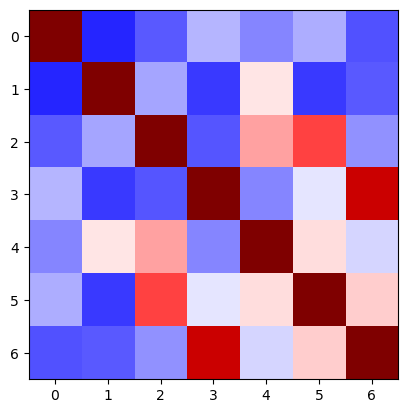

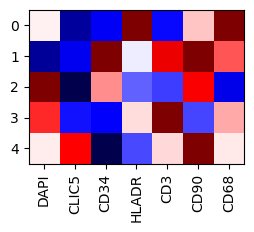

reading in pixels


100%|███████████████████████████████████████████████████████████████| 27/27 [00:05<00:00,  5.25it/s]


applying dimensionality reduction
visualizing


/Users/yakir/miniconda3/envs/torch/lib/python3.12/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


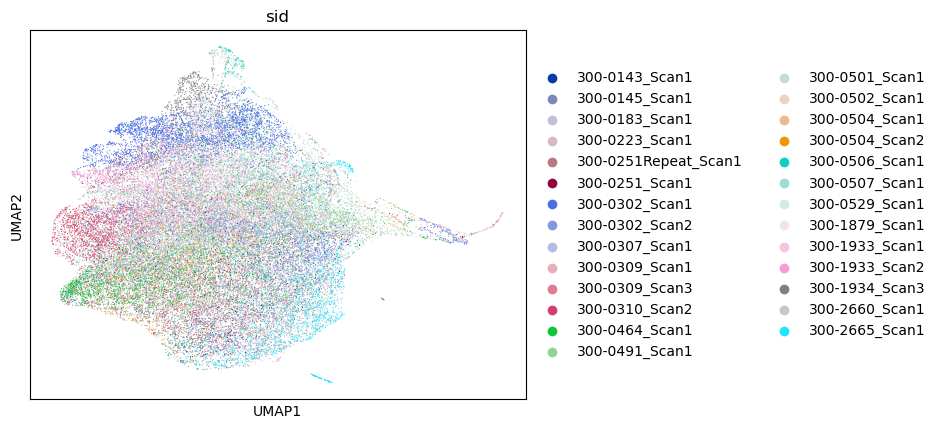

Please run the following command in your R environment:
Rscript /Users/yakir/Dropbox/py/vima/data/harmonize.R /Users/yakir/ST/RA/BHAM-data/10u/pca_k=5_harmony/_allpixels_pca.feather sid

When this finishes, run vi.post_harmony


In [6]:
# pre-harmony processing
vi.preprocess(outdir, repname, get_foreground, get_sumstats, normalize, nmetamarkers=nmetamarkers)

At this point, the user must separately open an R environment and run the command specified at the end of the above cell. In future versions we hope to remove this manual step.

We next read back in the output of `harmony` and create new sample files in the target directory

/Users/yakir/miniconda3/envs/torch/lib/python3.12/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


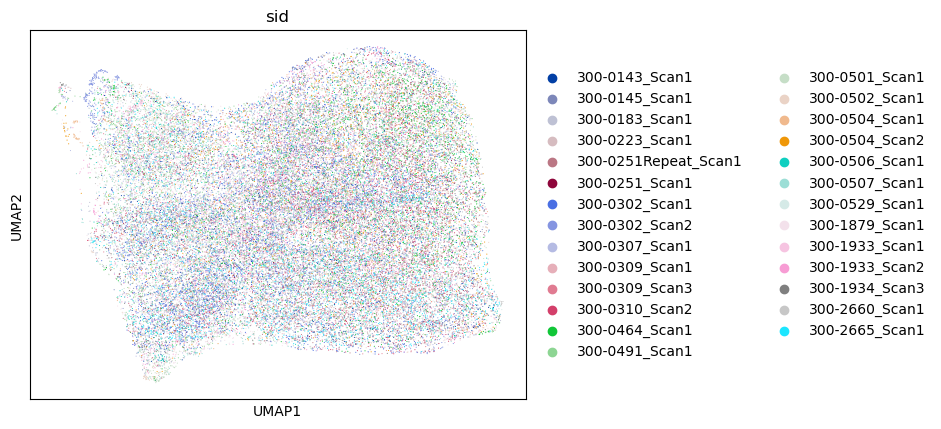

100%|███████████████████████████████████████████████████████████████| 27/27 [00:12<00:00,  2.12it/s]


In [7]:
# post-harmony processing
vi.post_harmony(outdir, repname, plot=True)

Finally, `vima` offers some sanity checks to give us a chance to spot any obvious problems

all PCs of one sample
histogram of each pc
01234

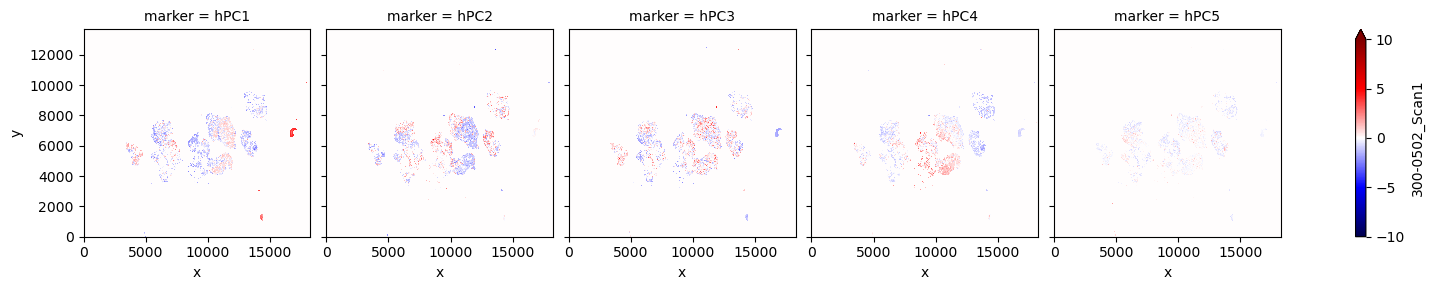

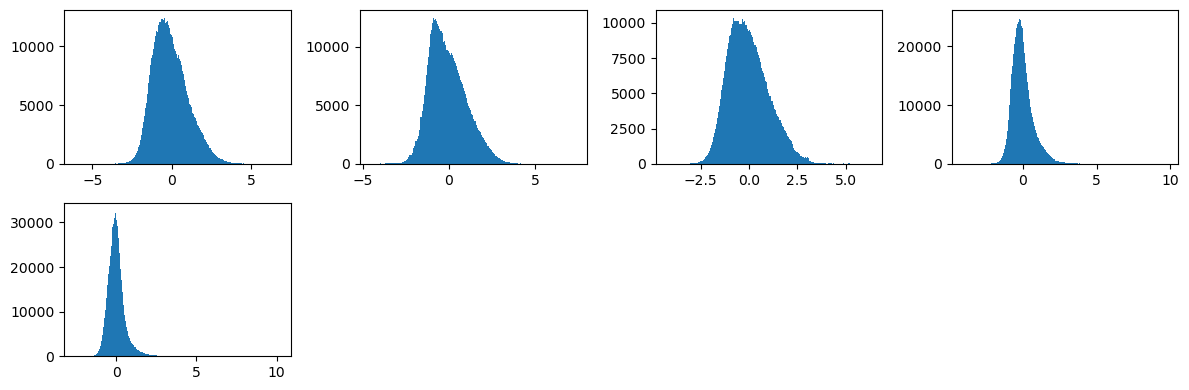

PC1 of several samples


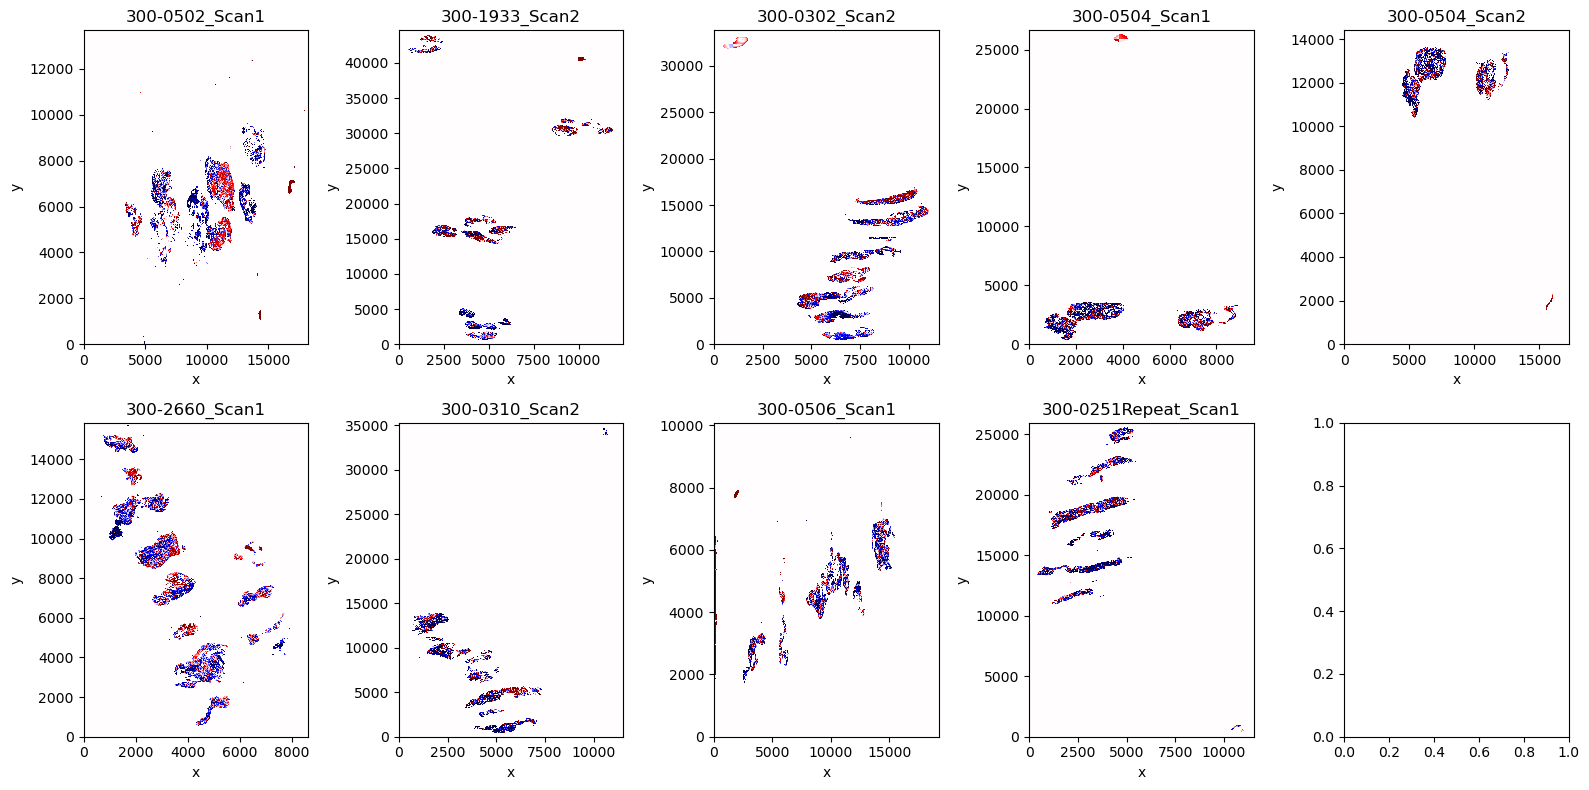

In [9]:
# visual sanity checks
vi.sanity_checks(outdir, repname)

## 2. Model training

We now turn to training the `vima` model on our preprocessed data. This involves reading in the data, generating tissue patches, and training the variational autoencoder.

In [2]:
vt.seed(0) # for maximal reproducibility
os.makedirs(f'./RA/_results', exist_ok=True)

We first read in all the samples together with their metadata

In [3]:
# read in samples
def fname_parser(fname):
    fname = fname.split('/')[-1].split('.nc')[0]
    return {
        'donor': fname.split('_')[0].replace('Repeat',''),
        'sid': fname
    }
repname = 'pca_k=5_harmony'
samples = vds.read_samples(f'RA/{repname}/*.nc', fname_parser)

# read in and reformat sample metadata
fullmeta = pd.read_csv('RA/metadata.csv').set_index('subject_id')[['CTAP']]
fullmeta.index = fullmeta.index.str.replace('V0', '') # reformat sample names
fullmeta['fstar'] = (fullmeta.CTAP == 'F') | (fullmeta.CTAP == 'T + F') | (fullmeta.CTAP == 'E + F + M') # define our phenotype

100%|███████████████████████████████████████████████████████████████| 27/27 [00:05<00:00,  4.74it/s]


We now generate two sets of patches: one for training, and a smaller set of "high-quality" patches for the case-control analysis

In [4]:
# choose which patches to train on
P = vdp.PatchCollection(samples)
print(len(P), 'patches')

# choose which patches to do case/ctrl analysis on
Pdense = vdp.PatchCollection(samples, max_frac_empty=0.2, sid_nums=P.sid_nums)
print(len(Pdense), 'dense patches')

# change samplemeta so that each row is a sample rather than a donor
inourdata = P.meta[['sid','donor']].drop_duplicates()
samplemeta = pd.merge(inourdata, fullmeta, left_on='donor', right_index=True, how='left').set_index('sid', drop=True)

100%|███████████████████████████████████████████████████████████████| 27/27 [00:06<00:00,  3.91it/s]


in pytorch mode
means: [-0.05243341 -0.03230548 -0.00229284 -0.02602001  0.00177622]
stds: [0.7899571  0.78198457 0.75690424 0.5287932  0.39302906]
data augmentation is off
39302 patches


100%|███████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  7.03it/s]


in pytorch mode
means: [-0.01986702  0.01847242  0.16045238  0.01280834  0.0355637 ]
stds: [1.003124  1.0235384 0.9741713 0.6844343 0.5384007]
data augmentation is off
10345 dense patches


Now that we have the patches we can train the autoencoder and save an instance of the trained model.

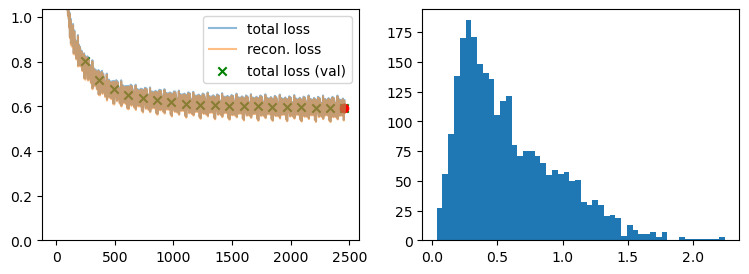

epoch 20. best validation loss = 0.5929325222969055
	total time: 54.52265810966492


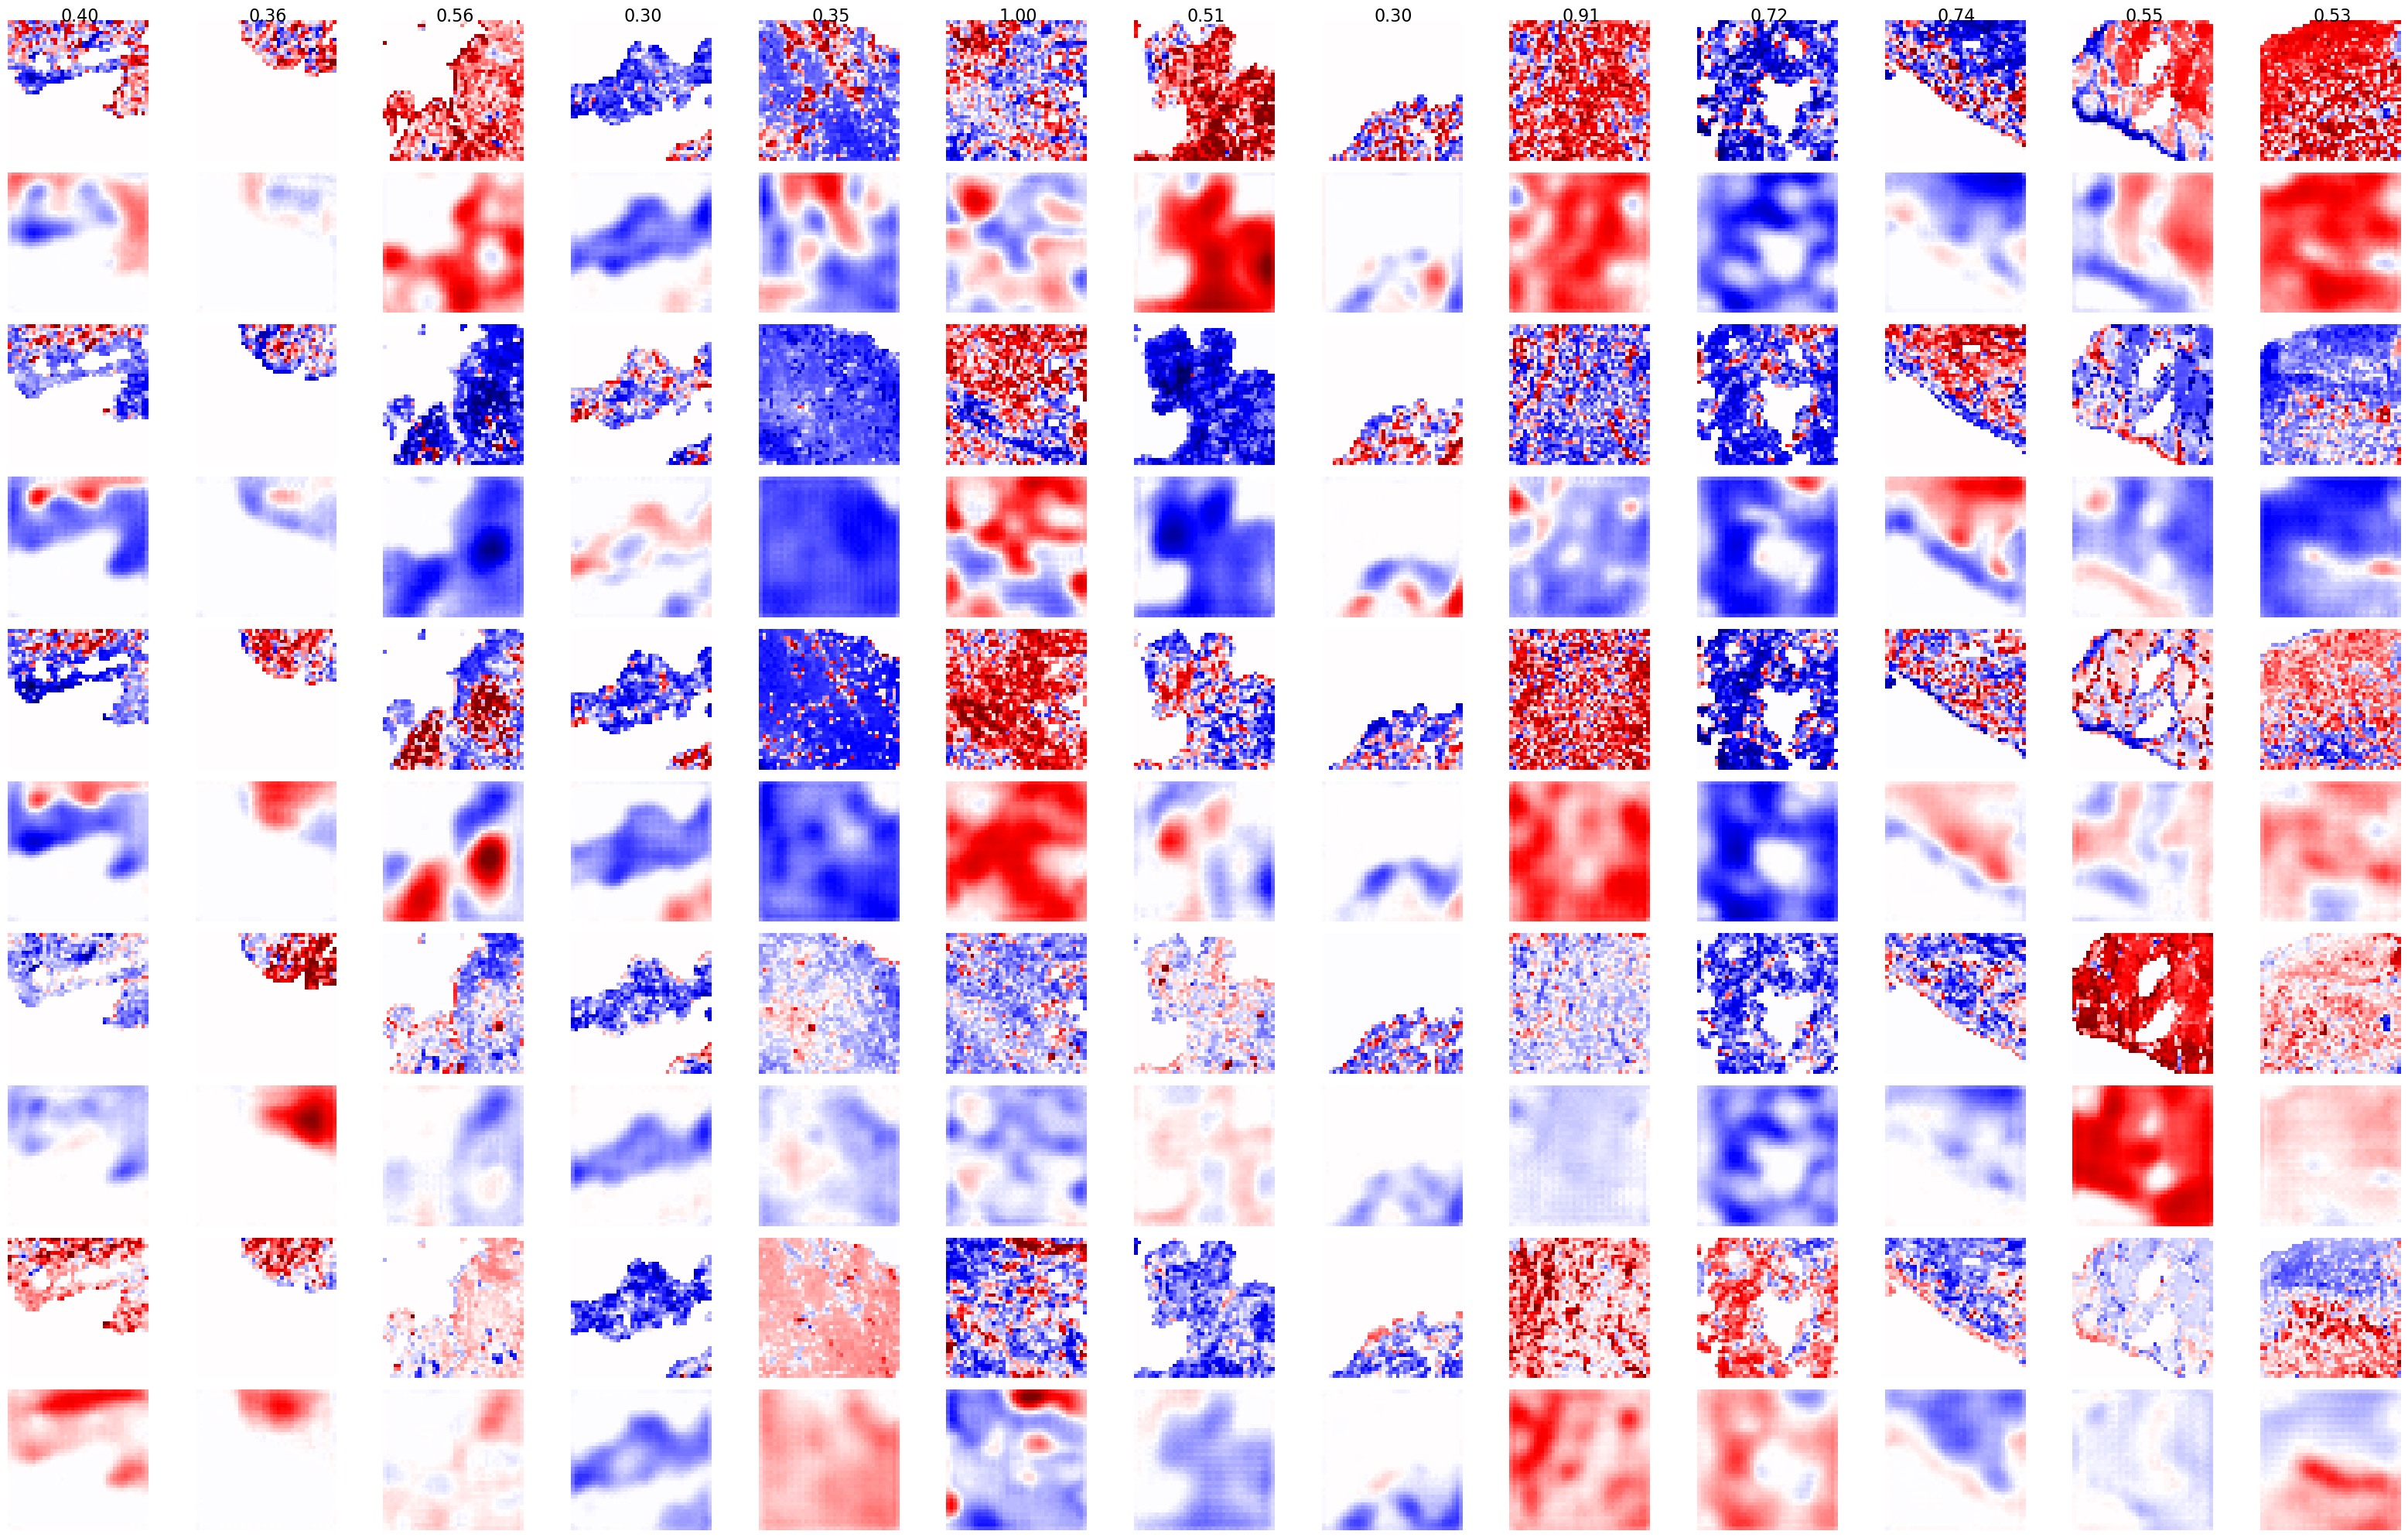

In [7]:
model = ResnetVAE(P.nmarkers, P.nsamples)

model, losslogs = vt.train(model, P)
torch.save(model.state_dict(), f'RA/_results/model.pt')

Once the model is trained, we load it from disk and apply it to the set of patches that are meant for case-control analysis to generate their patch fingerprints.

in pytorch mode
data augmentation is off


100%|███████████████████████████████████████████████████████████████| 11/11 [00:18<00:00,  1.70s/it]


running UMAP


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


done


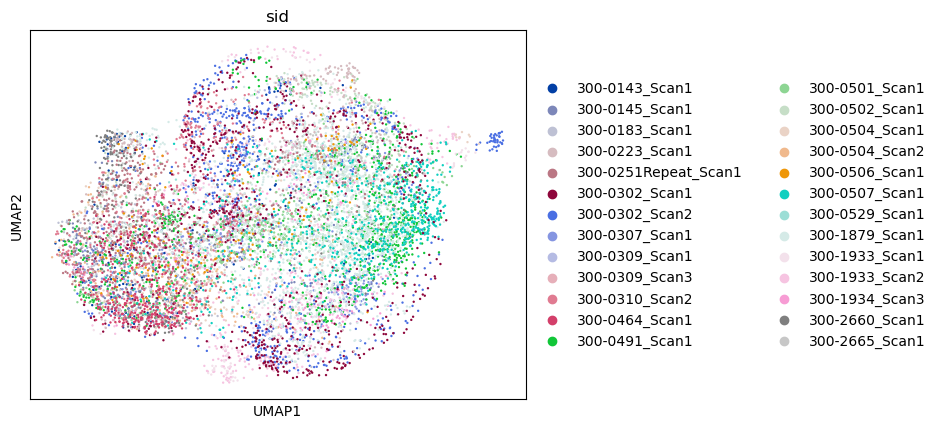

/var/folders/w_/x2_v44_93nq_b3svp199t1rw0000gn/T/ipykernel_74426/3265247800.py:8: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(Ddense)


In [ ]:
# load model
model = ResnetVAE(P.nmarkers, P.nsamples)
model.load_state_dict(torch.load(f'RA/_results/model.pt'))

# apply model and build umap
Ddense = va.latentrep(model, Pdense)
sc.pl.umap(Ddense, color='sid')
sc.tl.leiden(Ddense)
Ddense.uns['samplemeta'] = samplemeta
# Ddense.write(f'RA/_results/fingerprints.h5ad')

Now we can read in the the patch fingerprints and conduct the case-control analysis. The output is a global P-value for association as well as a set of significant microniches at FDR 10%.

## Case-control analysis

In [7]:
Ddense = sc.read_h5ad(f'RA/_results/fingerprints.h5ad')
samplem = Ddense.uns['sampleXmeta']
p = va.association(Ddense, samplem.fstar, 'sid', donorids=samplem.donor) # association returns the global p-value

P = 0.0008999100089991, used 2 MAM-PCs
Found 3588 microniches at FDR 10%


0.0008999100089991

We can then visualize the output by making a umap

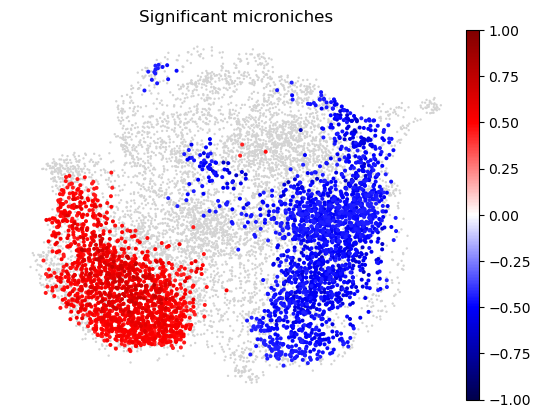

In [3]:
sc.pl.umap(Ddense, ax=plt.gca(), show=False, frameon=False)
sc.pl.umap(Ddense[Ddense.obs.sig_mncoeff != 0], color='sig_mncoeff', cmap='seismic', vmin=-1, vmax=1,
           ax=plt.gca(), frameon=False, title='Significant microniches')

Or we can look at the results programmatically

In [6]:
# the microniche correlations across all the microniches
Ddense.obs.mncoef

0       -0.491619
1       -0.694610
2       -0.595787
3        0.249353
4        0.316239
           ...   
10340    0.374344
10341    0.182003
10342    0.154393
10343    0.212471
10344    0.196372
Name: mncoef, Length: 10345, dtype: float64

In [8]:
# the FDR at which each microniche is significant
Ddense.obs.mncoef_fdr

0        0.066484
1        0.040427
2        0.043714
3        0.450387
4        0.275882
           ...   
10340    0.167170
10341    1.000000
10342    1.000000
10343    0.550243
10344    0.587574
Name: mncoef_fdr, Length: 10345, dtype: float64

In [14]:
# the microniche correlations across all the microniches, with non-significant microniches zero'd out
Ddense.obs.sig_mncoeff

0       -0.491619
1       -0.694610
2       -0.595787
3        0.000000
4        0.000000
           ...   
10340    0.000000
10341    0.000000
10342    0.000000
10343    0.000000
10344    0.000000
Name: sig_mncoeff, Length: 10345, dtype: float64

`vima` can also supply other information on the results if `association` is called with `return_full=True`